In [99]:
import os
import sys
PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
sys.path.append(os.path.join(PROJ_ROOT, 'src'))

%matplotlib inline
%config InlineBackend.figure_format ='retina'

%load_ext autoreload
%autoreload 2

%aimport data, model, features, plot

import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plot.plot import scatter_against_target_fig

from model.baselineestimator import estimate
from model.evaluation import score_rmse
from model.training import train
from features.selection import boruta
import features.selection as feature_selection
import features.extraction as feature_extraction

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression

In [3]:
from data.dataset import DataSet

traindf = DataSet.traindf[np.unique(DataSet.traindf.columns)]
testdf = DataSet.testdf[np.unique(DataSet.testdf.columns)]

X_train, y_train = traindf.drop(columns='target'), traindf.target
X_test, y_test = testdf.drop(columns='target'), testdf.target

In [4]:
print(f"train:\t{traindf.shape}")
print(f"test:\t{testdf.shape}")

train:	(249876, 915)
test:	(242972, 915)


In [6]:
print(f"Base line RMSE:\t\t{score_rmse(y_test, X_test.traff_mean):.3f}")

baseregressor = LGBMRegressor()
baseregressor.fit(X_train, y_train)
print(f"All features RMSE:\t{score_rmse(y_test, baseregressor.predict(X_test)): .3f}")

Base line RMSE:		9.393
All features RMSE:	 8.649


In [69]:
boruta_appearance, boruta_importance = boruta(X_train, y_train, iterations=20)

1. iteration is finished...  65.4s
2. iteration is finished...  63.0s
3. iteration is finished...  62.9s
4. iteration is finished...  57.6s
5. iteration is finished...  60.3s
6. iteration is finished...  60.1s
7. iteration is finished...  60.2s
8. iteration is finished...  60.4s
9. iteration is finished...  59.5s
10. iteration is finished...  60.8s
11. iteration is finished...  185.2s
12. iteration is finished...  62.3s
13. iteration is finished...  62.6s
14. iteration is finished...  60.4s
15. iteration is finished...  60.6s
16. iteration is finished...  61.3s
17. iteration is finished...  59.9s
18. iteration is finished...  60.2s
19. iteration is finished...  58.9s
20. iteration is finished...  59.6s


In [101]:
boruta_features = (boruta_appearance + boruta_importance)[boruta_appearance.where(lambda x: x >= 10).dropna().index]
px.bar(boruta_features.sort_values(ascending=False)).show()

NameError: name 'boruta_appearance' is not defined

In [ ]:
baseregressor.fit(X_train[list(boruta_features.index)], y_train)
print(f"All boruta features RMSE:\t{score_rmse(y_test, baseregressor.predict(X_test[list(boruta_features.index)])): .3f}")

In [100]:
fig = scatter_against_target_fig(
    traindf[list(boruta_features.sort_values(ascending=False).index) + ['target']],
    sample=2000)
fig.update_layout(height=1600, showlegend=False)
fig.show()
fig.write_html('scatter.html')

NameError: name 'boruta_features' is not defined

### Recursive feature elimination with cross-validation

In [239]:
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=LGBMRegressor(), step=1, cv=5,
              scoring='neg_root_mean_squared_error',
              min_features_to_select=1)
rfecv.fit(traindf[boruta_features.index], traindf.target);

RFECV(cv=5, estimator=LGBMRegressor(), scoring='neg_root_mean_squared_error')

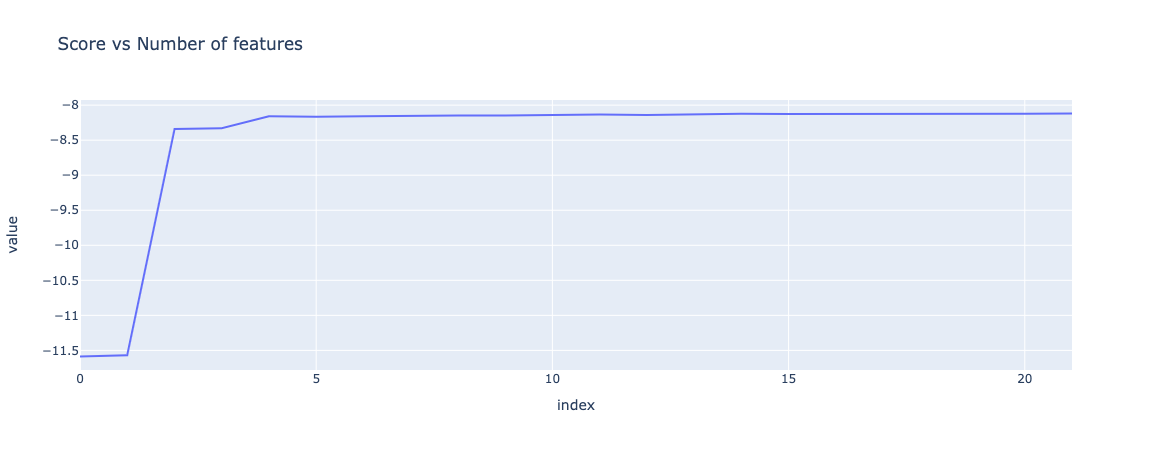

In [288]:
fig = px.line(rfecv.grid_scores_, title='Score vs Number of features',)
fig.update_layout(showlegend=False)

In [183]:
features_base = ['traff_m1', 'traff_mean', 'traff_m5']

In [189]:
other_non_traffic_features = [x for x in boruta_features.index if not x.startswith('traff')]

In [266]:
result = feature_selection.grid_search(traindf, features_base, other_non_traffic_features)

1. iteration is finished...  15.2s
2. iteration is finished...  138.1s
3. iteration is finished...  703.2s


In [284]:
results[0].sort_values(ascending=False)[:10]

(device_price,)                      -8.395244
(imei_mean_day_announced,)           -8.398678
(MV_ap_4G_d,)                        -8.398708
(dpi_upload,)                        -8.398805
(MV_Traf_4G_d_Mb,)                   -8.400750
(loc_lon,)                           -8.406778
(bs_succ_rate,)                      -8.408408
(non_accum_internet_vol_min_mnt3,)   -8.409487
(device_days_usage,)                 -8.410102
(non_accum_internet_vol_min_mnt1,)   -8.414260
dtype: float64

In [282]:
results[1].sort_values(ascending=False)[:10]

(MV_ap_4G_d, device_price, loc_lon)                                        -8.373452
(bs_succ_rate, device_price, imei_mean_day_announced)                      -8.375255
(MV_ap_4G_d, bs_succ_rate, device_price)                                   -8.375551
(bs_succ_rate, device_price, dpi_upload)                                   -8.378899
(MV_Traf_4G_d_Mb, bs_succ_rate, device_price)                              -8.379363
(MV_ap_4G_d, device_price, dpi_upload)                                     -8.379540
(bs_succ_rate, device_price, loc_lon)                                      -8.380605
(device_price, imei_mean_day_announced, non_accum_internet_vol_min_mnt1)   -8.380644
(MV_Traf_4G_d_Mb, MV_ap_4G_d, loc_lon)                                     -8.380789
(device_price, dpi_upload, imei_mean_day_announced)                        -8.380865
dtype: float64

In [283]:
results[2].sort_values(ascending=False)[:10]

(device_price, imei_mean_day_announced)           -8.384625
(bs_succ_rate, device_price)                      -8.385003
(MV_ap_4G_d, device_price)                        -8.386369
(MV_ap_4G_d, imei_mean_day_announced)             -8.386847
(MV_Traf_4G_d_Mb, dpi_upload)                     -8.387030
(MV_ap_4G_d, loc_lon)                             -8.390063
(MV_ap_4G_d, dpi_upload)                          -8.390979
(imei_mean_day_announced, loc_lon)                -8.391984
(device_price, non_accum_internet_vol_min_mnt1)   -8.392998
(MV_Traf_4G_d_Mb, device_price)                   -8.393546
dtype: float64

In [ ]:
pd.DataFrame((X_train[feat].isnull().mean() * 100).apply(lambda x: round(x, 3))).sort_values(by=0)

In [ ]:
features_selected = features_base + ['MV_ap_4G_d', 'bs_succ_rate', 'device_price']

In [296]:
baseregressor.fit(X_train[features_selected], y_train)
print(f"Selected features RMSE:\t{score_rmse(y_test, baseregressor.predict(X_test[features_selected])): .3f}")

All features RMSE:	 8.700
